# Roll Number
22F-3078 - Yahya Asif
22F-3387 - Ghayas Hussain

# Complete Urdu to Roman Transliteration with BiLSTM Seq2Seq Model

This notebook implements a sequence-to-sequence model with BiLSTM for transliterating Urdu text to Roman script. The implementation includes:
- Custom BPE tokenization implementation from scratch
- Encoder: 2-layer BiLSTM
- Decoder: 4-layer LSTM
- Teacher forcing during training
- Comprehensive evaluation with BLEU, CER, WER, and perplexity metrics
- Hyperparameter experiments to find the best model configuration

In [2]:
# 0. Setup and Imports
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader
import re
import os
import glob
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import json
import math
import random
from collections import defaultdict, Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 1. Clone and Prepare Dataset

In [4]:
# Set the path to the extracted dataset
DATA_DIR = "data/raw/rekhta/dataset/dataset"

# Verify the data directory exists
import os
print(f"Data directory exists: {os.path.exists(DATA_DIR)}")
print(f"Contents of data directory: {os.listdir(DATA_DIR)}")

# Authors list
authors = os.listdir(DATA_DIR)
print(f"Number of authors: {len(authors)}")

# Prepare lists to store Urdu-Roman pairs
pairs_with_file = []

# Load Urdu and Roman Urdu pairs
for author in authors:
    ur_path = os.path.join(DATA_DIR, author, "ur")
    en_path = os.path.join(DATA_DIR, author, "en")

    if not os.path.exists(ur_path) or not os.path.exists(en_path):
        continue

    ur_files = glob.glob(os.path.join(ur_path, "*"))

    for ufile in ur_files:
        fname = os.path.basename(ufile)
        efile = os.path.join(en_path, fname)

        if not os.path.exists(efile):
            continue

        with open(ufile, "r", encoding="utf-8") as f:
            ur_lines = f.read().splitlines()

        with open(efile, "r", encoding="utf-8") as f:
            en_lines = f.read().splitlines()

        # Ensure same number of lines
        if len(ur_lines) != len(en_lines):
            continue

        # Store pairs
        for ur, en in zip(ur_lines, en_lines):
            pairs_with_file.append({
                "ur_raw": ur.strip(),
                "en_raw": en.strip()
            })

print(f"Total paired lines: {len(pairs_with_file)}")

Data directory exists: True
Contents of data directory: ['.DS_Store', 'ahmad-faraz', 'akbar-allahabadi', 'allama-iqbal', 'altaf-hussain-hali', 'ameer-khusrau', 'bahadur-shah-zafar', 'dagh-dehlvi', 'fahmida-riaz', 'faiz-ahmad-faiz', 'firaq-gorakhpuri', 'gulzar', 'habib-jalib', 'jaan-nisar-akhtar', 'jaun-eliya', 'javed-akhtar', 'jigar-moradabadi', 'kaifi-azmi', 'meer-anees', 'meer-taqi-meer', 'mirza-ghalib', 'mohsin-naqvi', 'naji-shakir', 'naseer-turabi', 'nazm-tabatabai', 'nida-fazli', 'noon-meem-rashid', 'parveen-shakir', 'sahir-ludhianvi', 'wali-mohammad-wali', 'waseem-barelvi']
Number of authors: 31
Total paired lines: 22158


# 2. Data Preprocessing

In [5]:
# Normalize Urdu
def normalize_urdu(text: str) -> str:
    """
    Normalize Urdu text:
    - Remove extra spaces
    - Normalize certain characters like 'ۀ', 'ہ', etc.
    """
    # Remove unwanted punctuation
    text = re.sub(r"[ۂٰٖؔؕ]", "", text)

    # Replace Arabic-Indic digits with normal digits
    text = re.sub(r"[۰-۹]", lambda x: str(ord(x.group()) - 1776), text)

    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply normalization
for p in pairs_with_file:
    p["ur_norm"] = normalize_urdu(p["ur_raw"])

# Clean Roman Urdu
def clean_roman_safe(text: str) -> str:
    """
    Keep all diacritics, long vowels, nasalization.
    Only:
      - Lowercase
      - Normalize spaces
      - Replace fancy quotes/dashes
    """
    text = text.lower()
    text = text.replace("'", "'").replace("'", "'")
    text = text.replace(""", '"').replace(""", '"')
    text = text.replace("–", "-").replace("—", "-")
    text = text.replace("…", "...")
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply safe cleaning
for p in pairs_with_file:
    p["en_clean"] = clean_roman_safe(p["en_raw"])

# Save processed data
os.makedirs("data/processed", exist_ok=True)

with open("data/processed/source.txt", "w", encoding="utf-8") as fs, \
     open("data/processed/target.txt", "w", encoding="utf-8") as ft:
    for p in pairs_with_file:
        fs.write(p["ur_norm"] + "\n")
        ft.write(p["en_clean"] + "\n")

print("Data preprocessing completed.")

Data preprocessing completed.


# 3. Implement BPE Tokenizer from Scratch

In [6]:
class BPETokenizer:
    def __init__(self, vocab_size=10000, special_tokens=None):
        self.vocab_size = vocab_size
        self.special_tokens = special_tokens or ["[PAD]", "[UNK]", "[CLS]", "[SEP]"]
        self.vocab = {}
        self.merges = []
        self.word_freqs = {}
        self.token_to_id = {}
        self.id_to_token = {}
    
    def train(self, texts):
        # Initialize vocabulary with characters
        vocab = set()
        for text in texts:
            for word in text.split():
                word = " ".join(list(word)) + " </w>"
                vocab.update(word.split())
        
        # Add special tokens
        for token in self.special_tokens:
            vocab.add(token)
        
        # Create initial vocabulary
        self.vocab = list(vocab)
        self.token_to_id = {token: i for i, token in enumerate(self.vocab)}
        self.id_to_token = {i: token for i, token in enumerate(self.vocab)}
        
        # Count word frequencies
        word_freqs = Counter()
        for text in texts:
            for word in text.split():
                word = " ".join(list(word)) + " </w>"
                word_freqs[word] += 1
        
        # Perform BPE merges
        num_merges = self.vocab_size - len(self.vocab)
        for i in range(num_merges):
            # Find most frequent pair
            pairs = self.get_stats(word_freqs)
            if not pairs:
                break
            best_pair = max(pairs, key=pairs.get)
            
            # Merge the most frequent pair
            word_freqs = self.merge_vocab(best_pair, word_freqs)
            self.merges.append(best_pair)
            
            # Update vocabulary
            new_token = best_pair[0] + best_pair[1]
            if new_token not in self.token_to_id:
                self.token_to_id[new_token] = len(self.token_to_id)
                self.id_to_token[len(self.id_to_token)] = new_token
    
    def get_stats(self, vocab):
        pairs = defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pairs[symbols[i], symbols[i+1]] += freq
        return pairs
    
    def merge_vocab(self, pair, vocab):
        new_vocab = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?=!\S)')
        for word in vocab:
            new_word = p.sub(''.join(pair), word)
            new_vocab[new_word] = vocab[word]
        return new_vocab
    
    def encode(self, text):
        """Convert text to token IDs"""
        tokens = []
        for word in text.split():
            word = " ".join(list(word)) + " </w>"
            
            # Apply all merges
            for merge in self.merges:
                bigram = re.escape(' '.join(merge))
                p = re.compile(r'(?<!\S)' + bigram + r'(?=!\S)')
                word = p.sub(''.join(merge), word)
            
            # Split into tokens and convert to IDs
            subwords = word.split()
            for subword in subwords:
                if subword in self.token_to_id:
                    tokens.append(self.token_to_id[subword])
                else:
                    tokens.append(self.token_to_id["[UNK]"])
        
        return tokens
    
    def decode(self, ids):
        """Convert token IDs back to text"""
        tokens = []
        for id in ids:
            if id in self.id_to_token:
                token = self.id_to_token[id]
                # Remove </w> and spaces between subwords
                if token == "</w>":
                    continue
                if token.startswith("##"):
                    tokens.append(token[2:])
                else:
                    tokens.append(token.replace(" ", ""))
        
        # Combine tokens into words
        text = "".join(tokens)
        return text
    
    def save(self, path):
        data = {
            "vocab_size": self.vocab_size,
            "special_tokens": self.special_tokens,
            "merges": self.merges,
            "token_to_id": self.token_to_id,
            "id_to_token": self.id_to_token
        }
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False)
    
    @classmethod
    def load(cls, path):
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        tokenizer = cls(data["vocab_size"], data["special_tokens"])
        tokenizer.merges = [tuple(merge) for merge in data["merges"]]
        tokenizer.token_to_id = {k: v for k, v in data["token_to_id"].items()}
        tokenizer.id_to_token = {int(k): v for k, v in data["id_to_token"].items()}
        return tokenizer

# 4. Train BPE Tokenizer

In [7]:
# Prepare training data
source_texts = [p["ur_norm"] for p in pairs_with_file]
target_texts = [p["en_clean"] for p in pairs_with_file]
all_texts = source_texts + target_texts

# Initialize and train tokenizer
tokenizer = BPETokenizer(vocab_size=10000)
print("Training BPE tokenizer...")
tokenizer.train(all_texts)

# Save tokenizer
tokenizer.save("data/processed/bpe_tokenizer.json")

# Get special token IDs
PAD_ID = tokenizer.token_to_id["[PAD]"]
CLS_ID = tokenizer.token_to_id["[CLS]"]
SEP_ID = tokenizer.token_to_id["[SEP]"]
UNK_ID = tokenizer.token_to_id["[UNK]"]

# Get vocab size
vocab_size = len(tokenizer.token_to_id)
print(f"Vocabulary size: {vocab_size}")

# Example: encode first 3 lines
for i in range(3):
    source_encoded = tokenizer.encode(pairs_with_file[i]["ur_norm"])
    target_encoded = tokenizer.encode(pairs_with_file[i]["en_clean"])
    
    print(f"Source: {pairs_with_file[i]['ur_norm']}")
    print(f"Source tokens: {source_encoded}")
    print(f"Target: {pairs_with_file[i]['en_clean']}")
    print(f"Target tokens: {target_encoded}")
    print("---")

Training BPE tokenizer...
Vocabulary size: 98
Source: 
Source tokens: []
Target: 
Target tokens: []
---
Source: آنکھ سے دور نہ ہو دل سے اتر جائے گا
Source tokens: [52, 86, 76, 38, 21, 20, 68, 21, 26, 92, 48, 21, 86, 23, 21, 23, 92, 21, 26, 41, 21, 20, 68, 21, 56, 72, 48, 21, 17, 56, 74, 68, 21, 57, 56, 21]
Target: aañkh se duur na ho dil se utar jā.egā
Target tokens: [1, 1, 44, 39, 35, 21, 4, 14, 21, 30, 50, 50, 51, 21, 53, 1, 21, 35, 36, 21, 30, 71, 42, 21, 4, 14, 21, 50, 6, 1, 51, 21, 9, 82, 12, 14, 84, 82, 21]
---
Source: وقت کا کیا ہے گزرتا ہے گزر جائے گا
Source tokens: [92, 11, 72, 21, 76, 56, 21, 76, 85, 56, 21, 23, 68, 21, 57, 45, 48, 72, 56, 21, 23, 68, 21, 57, 45, 48, 21, 17, 56, 74, 68, 21, 57, 56, 21]
Target: vaqt kā kyā hai guzartā hai guzar jā.egā
Target tokens: [31, 1, 46, 6, 21, 39, 82, 21, 39, 32, 82, 21, 35, 1, 71, 21, 84, 50, 79, 1, 51, 6, 82, 21, 35, 1, 71, 21, 84, 50, 79, 1, 51, 21, 9, 82, 12, 14, 84, 82, 21]
---


# 5. Prepare Dataset and DataLoader

In [8]:
# Encode sequences to IDs
source_ids = [tokenizer.encode(p["ur_norm"]) for p in pairs_with_file]
target_ids = [tokenizer.encode(p["en_clean"]) for p in pairs_with_file]

# Add special tokens
source_ids = [[CLS_ID] + seq + [SEP_ID] for seq in source_ids]
target_ids = [[CLS_ID] + seq + [SEP_ID] for seq in target_ids]

# Convert to torch tensors and pad
source_tensors = [torch.tensor(seq) for seq in source_ids]
target_tensors = [torch.tensor(seq) for seq in target_ids]

# Pad sequences
source_padded = rnn_utils.pad_sequence(source_tensors, batch_first=True, padding_value=PAD_ID)
target_padded = rnn_utils.pad_sequence(target_tensors, batch_first=True, padding_value=PAD_ID)

print("Source shape:", source_padded.shape)
print("Target shape:", target_padded.shape)

# Create PyTorch Dataset
class Seq2SeqDataset(Dataset):
    def __init__(self, src, tgt):
        self.src = src
        self.tgt = tgt

    def __len__(self):
        return self.src.size(0)

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

# Split dataset: 50% train, 25% val, 25% test
N = len(source_padded)
train_end = N//2
val_end = train_end + N//4

train_dataset = Seq2SeqDataset(source_padded[:train_end], target_padded[:train_end])
val_dataset   = Seq2SeqDataset(source_padded[train_end:val_end], target_padded[train_end:val_end])
test_dataset  = Seq2SeqDataset(source_padded[val_end:], target_padded[val_end:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Source shape: torch.Size([22158, 93])
Target shape: torch.Size([22158, 105])
Train size: 11079, Val size: 5539, Test size: 5540


# 6. Define Model Architecture

In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_ID)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Bidirectional LSTM as required
        self.lstm = nn.LSTM(
            embed_size, hidden_size, num_layers=num_layers,
            batch_first=True, dropout=dropout, bidirectional=True
        )
        # Projection layers for combining bidirectional states
        self.h_projection = nn.Linear(2 * hidden_size, hidden_size)
        self.c_projection = nn.Linear(2 * hidden_size, hidden_size)

    def forward(self, src, src_len):
        """
        src: [batch, src_len]
        src_len: actual lengths (for packing)
        """
        emb = self.embedding(src)
        packed = rnn_utils.pack_padded_sequence(emb, src_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)
        out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        
        # Combine forward and backward hidden states
        # h and c are [2*num_layers, batch, hidden_size]
        # We take the last layer's forward and backward states
        h_forward = h[-2, :, :]  # Last layer forward
        h_backward = h[-1, :, :]  # Last layer backward
        h_combined = torch.cat((h_forward, h_backward), dim=1)  # [batch, 2*hidden_size]
        h_projected = self.h_projection(h_combined)  # [batch, hidden_size]
        
        c_forward = c[-2, :, :]
        c_backward = c[-1, :, :]
        c_combined = torch.cat((c_forward, c_backward), dim=1)
        c_projected = self.c_projection(c_combined)
        
        return out, (h_projected, c_projected)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=4, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_ID)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # 4 stacked LSTM layers as required
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, tgt, hidden):
        """
        tgt: [batch, tgt_len] (input tokens, e.g., <SOS> + previous tokens)
        hidden: tuple (h, c) each [num_layers, batch, hidden_size]
        """
        emb = self.embedding(tgt)
        out, hidden = self.lstm(emb, hidden)
        logits = self.fc_out(out)
        return logits, hidden

def init_decoder_hidden(enc_h, enc_c, num_layers_dec):
    """
    Initialize decoder hidden state from encoder final state
    Using identity mapping as required
    """
    # enc_h and enc_c are now [batch, hidden_size] (after projection)
    # Repeat for all decoder layers
    dec_h = enc_h.unsqueeze(0).repeat(num_layers_dec, 1, 1)
    dec_c = enc_c.unsqueeze(0).repeat(num_layers_dec, 1, 1)
    return dec_h, dec_c

# 7. Hyperparameter Experiments

In [10]:
# Define hyperparameter combinations to experiment with
hyperparameter_configs = [
    {"name": "exp1", "embed_size": 128, "hidden_size": 256, "num_layers_enc": 2, "num_layers_dec": 4, "dropout": 0.1, "lr": 1e-3, "batch_size": 32},
    {"name": "exp2", "embed_size": 256, "hidden_size": 512, "num_layers_enc": 2, "num_layers_dec": 4, "dropout": 0.3, "lr": 5e-4, "batch_size": 64},
    {"name": "exp3", "embed_size": 256, "hidden_size": 512, "num_layers_enc": 4, "num_layers_dec": 4, "dropout": 0.5, "lr": 1e-4, "batch_size": 128},
]

# Evaluation function
def evaluate(encoder, decoder, dataloader, criterion, num_layers_dec):
    encoder.eval()
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
        for batch_src, batch_tgt in dataloader:
            batch_src, batch_tgt = batch_src.to(device), batch_tgt.to(device)
            batch_src_len = (batch_src != PAD_ID).sum(dim=1)

            # Encoder forward pass
            enc_out, (enc_h, enc_c) = encoder(batch_src, batch_src_len)

            # Initialize decoder hidden state
            dec_h, dec_c = init_decoder_hidden(enc_h, enc_c, num_layers_dec)

            # First input to decoder is CLS token
            input_tok = batch_tgt[:, 0].unsqueeze(1)
            outputs = torch.zeros(batch_tgt.size(0), batch_tgt.size(1), vocab_size).to(device)

            # Decoder forward pass without teacher forcing
            for t in range(1, batch_tgt.size(1)):
                dec_out, (dec_h, dec_c) = decoder(input_tok, (dec_h, dec_c))
                outputs[:, t, :] = dec_out.squeeze(1)
                input_tok = dec_out.argmax(2)  # Use model's prediction as next input

            # Calculate loss
            outputs_flat = outputs[:, 1:].reshape(-1, vocab_size)
            target_flat = batch_tgt[:, 1:].reshape(-1)
            loss = criterion(outputs_flat, target_flat)

            total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train and evaluate a model with given hyperparameters
def run_experiment(config, train_loader, val_loader, test_loader, vocab_size, device):
    print(f"\n{'='*50}")
    print(f"Running experiment: {config['name']}")
    print(f"Hyperparameters: {config}")
    print(f"{'='*50}")
    
    # Initialize model with current config
    encoder = Encoder(vocab_size, config["embed_size"], config["hidden_size"], 
                      num_layers=config["num_layers_enc"], dropout=config["dropout"])
    decoder = Decoder(vocab_size, config["embed_size"], config["hidden_size"], 
                      num_layers=config["num_layers_dec"], dropout=config["dropout"])
    
    # Move to device
    encoder.to(device)
    decoder.to(device)
    
    # Initialize optimizer with current learning rate
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=config["lr"])
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    # Create data loaders with current batch size
    train_loader_exp = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader_exp = DataLoader(val_dataset, batch_size=config["batch_size"])
    test_loader_exp = DataLoader(test_dataset, batch_size=config["batch_size"])
    
    # Training parameters
    num_epochs = 50
    teacher_forcing_ratio = 0.5
    clip = 1.0
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    
    # For tracking metrics
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        total_loss = 0
        epoch_start_time = time.time()
        
        progress_bar = tqdm(train_loader_exp, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_src, batch_tgt in progress_bar:
            batch_src, batch_tgt = batch_src.to(device), batch_tgt.to(device)
            batch_src_len = (batch_src != PAD_ID).sum(dim=1)
            
            optimizer.zero_grad()
            
            # Encoder forward pass
            enc_out, (enc_h, enc_c) = encoder(batch_src, batch_src_len)
            
            # Decoder initialization
            dec_h, dec_c = init_decoder_hidden(enc_h, enc_c, config["num_layers_dec"])
            
            # First input to decoder is CLS token
            input_tok = batch_tgt[:, 0].unsqueeze(1)
            outputs = torch.zeros(batch_tgt.size(0), batch_tgt.size(1), vocab_size).to(device)
            
            # Decoder forward pass with teacher forcing
            for t in range(1, batch_tgt.size(1)):
                dec_out, (dec_h, dec_c) = decoder(input_tok, (dec_h, dec_c))
                outputs[:, t, :] = dec_out.squeeze(1)
                
                # Teacher forcing
                teacher_force = torch.rand(1).item() < teacher_forcing_ratio
                top1 = dec_out.argmax(2)
                input_tok = batch_tgt[:, t].unsqueeze(1) if teacher_force else top1
            
            # Loss calculation
            outputs_flat = outputs[:, 1:].reshape(-1, vocab_size)
            target_flat = batch_tgt[:, 1:].reshape(-1)
            loss = criterion(outputs_flat, target_flat)
            
            # Backpropagation
            loss.backward()
            nn.utils.clip_grad_norm_(
                list(encoder.parameters()) + list(decoder.parameters()),
                clip
            )
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader_exp)
        train_losses.append(avg_loss)
        
        # Validation
        val_loss = evaluate(encoder, decoder, val_loader_exp, criterion, config["num_layers_dec"])
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save best model for this experiment
            torch.save({
                'encoder': encoder.state_dict(),
                'decoder': decoder.state_dict(),
                'optimizer': optimizer.state_dict(),
                'config': config,
                'train_losses': train_losses,
                'val_losses': val_losses
            }, f"{config['name']}_best_model.pt")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.2f}s")
    
    # Evaluate on test set
    test_loss = evaluate(encoder, decoder, test_loader_exp, criterion, config["num_layers_dec"])
    print(f"Test Loss: {test_loss:.4f}")
    
    # Load best model for final evaluation
    checkpoint = torch.load(f"{config['name']}_best_model.pt")
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    
    # Create transliterator for this model
    transliterator = Transliterator(encoder, decoder, tokenizer, device, config["num_layers_dec"])
    
    # Run comprehensive evaluation
    print("Running comprehensive evaluation...")
    results = evaluate_comprehensive(transliterator, test_pairs, num_samples=200)
    
    # Print summary metrics
    print("\n" + "="*50)
    print(f"EVALUATION SUMMARY FOR {config['name']}")
    print("="*50)
    print(f"BLEU Score: {results['avg_bleu']:.2f}")
    print(f"Character Error Rate (CER): {results['avg_cer']:.2%}")
    print(f"Word Error Rate (WER): {results['avg_wer']:.2%}")
    print(f"Exact Match Rate: {results['exact_match_rate']:.2%}")
    print(f"Perplexity: {results['perplexity']:.2f}")
    print("="*50)
    
    # Return results
    return {
        'name': config['name'],
        'config': config,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_loss': test_loss,
        'best_val_loss': best_val_loss,
        'results': results
    }

# 8. Transliterator and Evaluation Functions

In [11]:
# Transliterator class
class Transliterator:
    def __init__(self, encoder, decoder, tokenizer, device, num_layers_dec):
        self.encoder = encoder
        self.decoder = decoder
        self.tokenizer = tokenizer
        self.device = device
        self.num_layers_dec = num_layers_dec

    def normalize_urdu(self, text):
        """Normalize Urdu text"""
        text = re.sub(r"[ۂٰٖؔؕ]", "", text)  # remove extra diacritics
        text = re.sub(r"[۰-۹]", lambda x: str(ord(x.group())-1776), text)  # Arabic numerals
        text = re.sub(r"\s+", " ", text).strip()
        return text

    def init_decoder_hidden(self, enc_h, enc_c):
        """Initialize decoder hidden state from encoder hidden state"""
        # Take the final encoder state (from last layer)
        final_h = enc_h[-1]  # Shape: [batch_size, hidden_size]
        final_c = enc_c[-1]  # Shape: [batch_size, hidden_size]

        # Repeat for all decoder layers (identity mapping)
        dec_h = final_h.unsqueeze(0).repeat(self.num_layers_dec, 1, 1)
        dec_c = final_c.unsqueeze(0).repeat(self.num_layers_dec, 1, 1)

        return dec_h, dec_c

    def transliterate(self, urdu_text, max_len=50):
        """Transliterate Urdu text to Roman script"""
        self.encoder.eval()
        self.decoder.eval()

        # Normalize and tokenize
        urdu_norm = self.normalize_urdu(urdu_text)
        tokens = [CLS_ID] + self.tokenizer.encode(urdu_norm) + [SEP_ID]
        src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(self.device)
        src_len = torch.LongTensor([len(tokens)]).to(self.device)

        with torch.no_grad():
            # Encoder forward pass
            enc_out, (enc_h, enc_c) = self.encoder(src_tensor, src_len)

            # Initialize decoder hidden state
            dec_h, dec_c = self.init_decoder_hidden(enc_h, enc_c)

            # Start with CLS token
            input_tok = torch.LongTensor([[CLS_ID]]).to(self.device)

            result = []

            # Generate transliteration
            for t in range(max_len):
                dec_out, (dec_h, dec_c) = self.decoder(input_tok, (dec_h, dec_c))
                pred_token = dec_out.argmax(2).item()

                if pred_token == SEP_ID:
                    break

                result.append(pred_token)
                input_tok = torch.LongTensor([[pred_token]]).to(self.device)

        # Convert token IDs to text
        roman_text = self.tokenizer.decode(result)
        return roman_text

# Evaluation functions
def calculate_bleu(reference, hypothesis):
    """Calculate BLEU score"""
    try:
        # Simple BLEU calculation (using 1-gram, 2-gram, 3-gram, 4-gram)
        reference_tokens = reference.split()
        hypothesis_tokens = hypothesis.split()
        
        if len(hypothesis_tokens) == 0:
            return 0.0
        
        # Calculate precision for each n-gram
        precisions = []
        for n in range(1, 5):
            reference_ngrams = list(zip(*[reference_tokens[i:] for i in range(n)]))
            hypothesis_ngrams = list(zip(*[hypothesis_tokens[i:] for i in range(n)]))
            
            if len(hypothesis_ngrams) == 0:
                precisions.append(0)
                continue
            
            # Count matching n-grams
            matches = sum(1 for ngram in hypothesis_ngrams if ngram in reference_ngrams)
            precision = matches / len(hypothesis_ngrams)
            precisions.append(precision)
        
        # Calculate brevity penalty
        if len(hypothesis_tokens) > len(reference_tokens):
            bp = 1.0
        else:
            bp = math.exp(1 - len(reference_tokens) / len(hypothesis_tokens)) if len(hypothesis_tokens) > 0 else 0.0
        
        # Calculate geometric mean of precisions
        if all(p > 0 for p in precisions):
            score = bp * math.exp(sum(math.log(p) for p in precisions) / len(precisions))
        else:
            score = 0.0
        
        return score * 100  # Return as percentage
    except:
        return 0.0

def calculate_perplexity(loss):
    """Calculate perplexity from loss"""
    try:
        return math.exp(loss)
    except:
        return float('inf')

def calculate_cer(reference, hypothesis):
    """Calculate Character Error Rate using edit distance"""
    try:
        ref_chars = list(reference.replace(' ', ''))
        hyp_chars = list(hypothesis.replace(' ', ''))

        # Calculate edit distance
        distance = editdistance(ref_chars, hyp_chars)

        # CER = (Substitutions + Deletions + Insertions) / Reference length
        cer = distance / len(ref_chars) if len(ref_chars) > 0 else 1.0
        return cer
    except:
        return 1.0

def calculate_wer(reference, hypothesis):
    """Calculate Word Error Rate"""
    try:
        ref_words = reference.split()
        hyp_words = hypothesis.split()

        # Calculate edit distance
        distance = editdistance(ref_words, hyp_words)

        # WER = (Substitutions + Deletions + Insertions) / Reference length
        wer = distance / len(ref_words) if len(ref_words) > 0 else 1.0
        return wer
    except:
        return 1.0

def editdistance(s1, s2):
    """Calculate edit distance between two sequences"""
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    
    return distances[-1]

def evaluate_comprehensive(transliterator, test_pairs, num_samples=None):
    """Evaluate model with multiple metrics"""
    if num_samples is None:
        num_samples = len(test_pairs)

    # Sample test pairs
    sample_indices = np.random.choice(len(test_pairs), min(num_samples, len(test_pairs)), replace=False)

    # Initialize metrics
    bleu_scores = []
    cer_scores = []
    wer_scores = []
    exact_matches = 0

    # Store examples for qualitative analysis
    examples = []

    for idx in sample_indices:
        pair = test_pairs[idx]
        urdu_text = pair["ur_norm"]
        reference = pair["en_clean"]

        # Get model prediction
        prediction = transliterator.transliterate(urdu_text)

        # Calculate metrics
        bleu = calculate_bleu(reference, prediction)
        cer = calculate_cer(reference, prediction)
        wer = calculate_wer(reference, prediction)

        bleu_scores.append(bleu)
        cer_scores.append(cer)
        wer_scores.append(wer)

        if reference.strip() == prediction.strip():
            exact_matches += 1

        # Store examples
        examples.append({
            "urdu": urdu_text,
            "reference": reference,
            "prediction": prediction,
            "bleu": bleu,
            "cer": cer,
            "wer": wer
        })

    # Calculate average metrics
    avg_bleu = np.mean(bleu_scores)
    avg_cer = np.mean(cer_scores)
    avg_wer = np.mean(wer_scores)
    exact_match_rate = exact_matches / len(sample_indices)

    # Calculate perplexity from test loss
    test_loss = evaluate(transliterator.encoder, transliterator.decoder, test_loader, 
                        nn.CrossEntropyLoss(ignore_index=PAD_ID), transliterator.num_layers_dec)
    perplexity = calculate_perplexity(test_loss)

    return {
        "avg_bleu": avg_bleu,
        "avg_cer": avg_cer,
        "avg_wer": avg_wer,
        "exact_match_rate": exact_match_rate,
        "perplexity": perplexity,
        "examples": examples
    }

# 9. Run Experiments

Total pairs: 22158
Train pairs: 11079
Validation pairs: 5539
Test pairs: 5540

Running experiment: exp1
Hyperparameters: {'name': 'exp1', 'embed_size': 128, 'hidden_size': 256, 'num_layers_enc': 2, 'num_layers_dec': 4, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 32}


Epoch 1/50: 100%|██████████| 347/347 [00:59<00:00,  5.84it/s, loss=2.7227]


Epoch 1/50 | Train Loss: 2.9972 | Val Loss: 3.0607 | Time: 66.55s


Epoch 2/50: 100%|██████████| 347/347 [00:59<00:00,  5.80it/s, loss=2.7902]


Epoch 2/50 | Train Loss: 2.6847 | Val Loss: 3.0688 | Time: 66.72s


Epoch 3/50: 100%|██████████| 347/347 [00:59<00:00,  5.80it/s, loss=2.5030]


Epoch 3/50 | Train Loss: 2.5001 | Val Loss: 3.0305 | Time: 66.72s


Epoch 4/50: 100%|██████████| 347/347 [01:00<00:00,  5.75it/s, loss=2.3826]


Epoch 4/50 | Train Loss: 2.3938 | Val Loss: 2.9747 | Time: 67.41s


Epoch 5/50: 100%|██████████| 347/347 [01:00<00:00,  5.77it/s, loss=2.0334]


Epoch 5/50 | Train Loss: 2.2890 | Val Loss: 2.9645 | Time: 67.02s


Epoch 6/50: 100%|██████████| 347/347 [00:59<00:00,  5.79it/s, loss=2.1650]


Epoch 6/50 | Train Loss: 2.2066 | Val Loss: 2.9092 | Time: 66.82s


Epoch 7/50: 100%|██████████| 347/347 [00:59<00:00,  5.84it/s, loss=1.9624]


Epoch 7/50 | Train Loss: 2.1353 | Val Loss: 2.9632 | Time: 66.48s


Epoch 8/50: 100%|██████████| 347/347 [01:00<00:00,  5.75it/s, loss=2.1202]


Epoch 8/50 | Train Loss: 2.0745 | Val Loss: 2.8425 | Time: 67.26s


Epoch 9/50: 100%|██████████| 347/347 [01:00<00:00,  5.73it/s, loss=1.9724]


Epoch 9/50 | Train Loss: 2.0191 | Val Loss: 2.8365 | Time: 67.84s


Epoch 10/50: 100%|██████████| 347/347 [00:59<00:00,  5.79it/s, loss=1.8131]


Epoch 10/50 | Train Loss: 1.9564 | Val Loss: 2.8543 | Time: 66.95s


Epoch 11/50: 100%|██████████| 347/347 [01:00<00:00,  5.76it/s, loss=1.5536]


Epoch 11/50 | Train Loss: 1.8955 | Val Loss: 2.8466 | Time: 67.24s


Epoch 12/50: 100%|██████████| 347/347 [01:00<00:00,  5.76it/s, loss=1.8179]


Epoch 12/50 | Train Loss: 1.8515 | Val Loss: 2.8226 | Time: 67.44s


Epoch 13/50: 100%|██████████| 347/347 [01:00<00:00,  5.77it/s, loss=1.9265]


Epoch 13/50 | Train Loss: 1.7989 | Val Loss: 2.7943 | Time: 67.36s


Epoch 14/50: 100%|██████████| 347/347 [01:00<00:00,  5.76it/s, loss=1.6332]


Epoch 14/50 | Train Loss: 1.7542 | Val Loss: 2.8585 | Time: 67.19s


Epoch 15/50: 100%|██████████| 347/347 [01:00<00:00,  5.76it/s, loss=1.7665]


Epoch 15/50 | Train Loss: 1.7067 | Val Loss: 2.8267 | Time: 67.06s


Epoch 16/50: 100%|██████████| 347/347 [01:00<00:00,  5.75it/s, loss=1.6366]


Epoch 16/50 | Train Loss: 1.6738 | Val Loss: 2.8556 | Time: 67.60s


Epoch 17/50: 100%|██████████| 347/347 [01:00<00:00,  5.75it/s, loss=1.6193]


Epoch 17/50 | Train Loss: 1.5771 | Val Loss: 2.7095 | Time: 67.49s


Epoch 18/50: 100%|██████████| 347/347 [00:59<00:00,  5.79it/s, loss=1.6156]


Epoch 18/50 | Train Loss: 1.5511 | Val Loss: 2.7923 | Time: 66.78s


Epoch 19/50: 100%|██████████| 347/347 [00:59<00:00,  5.79it/s, loss=1.3733]


Epoch 19/50 | Train Loss: 1.5151 | Val Loss: 2.8462 | Time: 66.77s


Epoch 20/50: 100%|██████████| 347/347 [00:54<00:00,  6.42it/s, loss=1.3114]


Epoch 20/50 | Train Loss: 1.4808 | Val Loss: 2.7480 | Time: 61.19s


Epoch 21/50: 100%|██████████| 347/347 [00:54<00:00,  6.37it/s, loss=1.8098]


Epoch 21/50 | Train Loss: 1.4354 | Val Loss: 2.7775 | Time: 61.41s


Epoch 22/50: 100%|██████████| 347/347 [00:55<00:00,  6.30it/s, loss=1.6923]


Early stopping at epoch 22
Test Loss: 2.7026
Running comprehensive evaluation...

EVALUATION SUMMARY FOR exp1
BLEU Score: 0.00
Character Error Rate (CER): 60.65%
Word Error Rate (WER): 100.00%
Exact Match Rate: 7.00%
Perplexity: 14.14

Running experiment: exp2
Hyperparameters: {'name': 'exp2', 'embed_size': 256, 'hidden_size': 512, 'num_layers_enc': 2, 'num_layers_dec': 4, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}


Epoch 1/50: 100%|██████████| 174/174 [00:30<00:00,  5.65it/s, loss=2.9095]


Epoch 1/50 | Train Loss: 3.0433 | Val Loss: 3.0326 | Time: 35.14s


Epoch 2/50: 100%|██████████| 174/174 [00:30<00:00,  5.71it/s, loss=2.6468]


Epoch 2/50 | Train Loss: 2.8344 | Val Loss: 2.9650 | Time: 34.86s


Epoch 3/50: 100%|██████████| 174/174 [00:30<00:00,  5.68it/s, loss=2.5317]


Epoch 3/50 | Train Loss: 2.5680 | Val Loss: 2.9167 | Time: 34.93s


Epoch 4/50: 100%|██████████| 174/174 [00:30<00:00,  5.73it/s, loss=2.3850]


Epoch 4/50 | Train Loss: 2.4169 | Val Loss: 2.8762 | Time: 34.69s


Epoch 5/50: 100%|██████████| 174/174 [00:30<00:00,  5.67it/s, loss=2.1739]


Epoch 5/50 | Train Loss: 2.2967 | Val Loss: 2.8756 | Time: 35.07s


Epoch 6/50: 100%|██████████| 174/174 [00:30<00:00,  5.67it/s, loss=1.9539]


Epoch 6/50 | Train Loss: 2.2064 | Val Loss: 2.7878 | Time: 35.00s


Epoch 7/50: 100%|██████████| 174/174 [00:30<00:00,  5.71it/s, loss=1.8409]


Epoch 7/50 | Train Loss: 2.1132 | Val Loss: 2.8385 | Time: 34.29s


Epoch 8/50: 100%|██████████| 174/174 [00:30<00:00,  5.65it/s, loss=2.0504]


Epoch 8/50 | Train Loss: 2.0293 | Val Loss: 2.7039 | Time: 35.17s


Epoch 9/50: 100%|██████████| 174/174 [00:30<00:00,  5.71it/s, loss=2.1632]


Epoch 9/50 | Train Loss: 1.9106 | Val Loss: 2.7942 | Time: 34.25s


Epoch 10/50: 100%|██████████| 174/174 [00:30<00:00,  5.66it/s, loss=1.8299]


Epoch 10/50 | Train Loss: 1.8172 | Val Loss: 2.6492 | Time: 35.15s


Epoch 11/50: 100%|██████████| 174/174 [00:30<00:00,  5.67it/s, loss=1.4501]


Epoch 11/50 | Train Loss: 1.7014 | Val Loss: 2.7036 | Time: 34.53s


Epoch 12/50: 100%|██████████| 174/174 [00:30<00:00,  5.68it/s, loss=1.6323]


Epoch 12/50 | Train Loss: 1.6221 | Val Loss: 2.6186 | Time: 35.01s


Epoch 13/50: 100%|██████████| 174/174 [00:30<00:00,  5.68it/s, loss=1.4164]


Epoch 13/50 | Train Loss: 1.5219 | Val Loss: 2.6416 | Time: 34.48s


Epoch 14/50: 100%|██████████| 174/174 [00:30<00:00,  5.63it/s, loss=1.6484]


Epoch 14/50 | Train Loss: 1.4231 | Val Loss: 2.6099 | Time: 35.34s


Epoch 15/50: 100%|██████████| 174/174 [00:30<00:00,  5.67it/s, loss=1.3577]


Epoch 15/50 | Train Loss: 1.3341 | Val Loss: 2.6752 | Time: 34.54s


Epoch 16/50: 100%|██████████| 174/174 [00:30<00:00,  5.69it/s, loss=1.2443]


Epoch 16/50 | Train Loss: 1.2651 | Val Loss: 2.5243 | Time: 34.90s


Epoch 17/50: 100%|██████████| 174/174 [00:30<00:00,  5.66it/s, loss=0.9887]


Epoch 17/50 | Train Loss: 1.1968 | Val Loss: 2.6245 | Time: 34.56s


Epoch 18/50: 100%|██████████| 174/174 [00:30<00:00,  5.68it/s, loss=1.4399]


Epoch 18/50 | Train Loss: 1.1199 | Val Loss: 2.6393 | Time: 34.36s


Epoch 19/50: 100%|██████████| 174/174 [00:30<00:00,  5.71it/s, loss=0.8702]


Epoch 19/50 | Train Loss: 1.0594 | Val Loss: 2.5575 | Time: 34.35s


Epoch 20/50: 100%|██████████| 174/174 [00:30<00:00,  5.65it/s, loss=0.6398]


Epoch 20/50 | Train Loss: 0.9481 | Val Loss: 2.5866 | Time: 34.60s


Epoch 21/50: 100%|██████████| 174/174 [00:30<00:00,  5.72it/s, loss=0.9018]


Early stopping at epoch 21
Test Loss: 2.5273
Running comprehensive evaluation...

EVALUATION SUMMARY FOR exp2
BLEU Score: 0.00
Character Error Rate (CER): 51.24%
Word Error Rate (WER): 100.00%
Exact Match Rate: 6.50%
Perplexity: 11.45

Running experiment: exp3
Hyperparameters: {'name': 'exp3', 'embed_size': 256, 'hidden_size': 512, 'num_layers_enc': 4, 'num_layers_dec': 4, 'dropout': 0.5, 'lr': 0.0001, 'batch_size': 128}


Epoch 1/50: 100%|██████████| 87/87 [00:18<00:00,  4.58it/s, loss=3.0620]


Epoch 1/50 | Train Loss: 3.4156 | Val Loss: 3.0876 | Time: 22.51s


Epoch 2/50: 100%|██████████| 87/87 [00:18<00:00,  4.62it/s, loss=2.9864]


Epoch 2/50 | Train Loss: 3.0135 | Val Loss: 3.0320 | Time: 22.29s


Epoch 3/50: 100%|██████████| 87/87 [00:18<00:00,  4.58it/s, loss=2.9735]


Epoch 3/50 | Train Loss: 2.9771 | Val Loss: 3.0314 | Time: 22.55s


Epoch 4/50: 100%|██████████| 87/87 [00:18<00:00,  4.61it/s, loss=2.9594]


Epoch 4/50 | Train Loss: 2.9658 | Val Loss: 3.0118 | Time: 22.32s


Epoch 5/50: 100%|██████████| 87/87 [00:18<00:00,  4.61it/s, loss=2.9341]


Epoch 5/50 | Train Loss: 2.9550 | Val Loss: 3.0045 | Time: 22.28s


Epoch 6/50: 100%|██████████| 87/87 [00:19<00:00,  4.54it/s, loss=2.9644]


Epoch 6/50 | Train Loss: 2.9494 | Val Loss: 2.9991 | Time: 22.64s


Epoch 7/50: 100%|██████████| 87/87 [00:18<00:00,  4.60it/s, loss=2.9295]


Epoch 7/50 | Train Loss: 2.9426 | Val Loss: 2.9941 | Time: 22.34s


Epoch 8/50: 100%|██████████| 87/87 [00:18<00:00,  4.61it/s, loss=2.9450]


Epoch 8/50 | Train Loss: 2.9355 | Val Loss: 2.9736 | Time: 22.41s


Epoch 9/50: 100%|██████████| 87/87 [00:18<00:00,  4.60it/s, loss=2.9355]


Epoch 9/50 | Train Loss: 2.9295 | Val Loss: 2.9708 | Time: 22.35s


Epoch 10/50: 100%|██████████| 87/87 [00:18<00:00,  4.62it/s, loss=2.9032]


Epoch 10/50 | Train Loss: 2.9153 | Val Loss: 2.9517 | Time: 22.35s


Epoch 11/50: 100%|██████████| 87/87 [00:18<00:00,  4.63it/s, loss=2.8279]


Epoch 11/50 | Train Loss: 2.8906 | Val Loss: 2.9555 | Time: 21.19s


Epoch 12/50: 100%|██████████| 87/87 [00:18<00:00,  4.65it/s, loss=2.7725]


Epoch 12/50 | Train Loss: 2.8116 | Val Loss: 2.9515 | Time: 22.19s


Epoch 13/50: 100%|██████████| 87/87 [00:18<00:00,  4.63it/s, loss=2.7299]


Epoch 13/50 | Train Loss: 2.7340 | Val Loss: 2.9514 | Time: 22.34s


Epoch 14/50: 100%|██████████| 87/87 [00:18<00:00,  4.60it/s, loss=2.6726]


Epoch 14/50 | Train Loss: 2.6846 | Val Loss: 2.9295 | Time: 22.35s


Epoch 15/50: 100%|██████████| 87/87 [00:18<00:00,  4.60it/s, loss=2.6839]


Epoch 15/50 | Train Loss: 2.6454 | Val Loss: 2.9150 | Time: 22.45s


Epoch 16/50: 100%|██████████| 87/87 [00:18<00:00,  4.58it/s, loss=2.6645]


Epoch 16/50 | Train Loss: 2.6259 | Val Loss: 2.8996 | Time: 22.43s


Epoch 17/50: 100%|██████████| 87/87 [00:18<00:00,  4.59it/s, loss=2.5815]


Epoch 17/50 | Train Loss: 2.5885 | Val Loss: 2.9098 | Time: 21.36s


Epoch 18/50: 100%|██████████| 87/87 [00:19<00:00,  4.55it/s, loss=2.5957]


Epoch 18/50 | Train Loss: 2.5655 | Val Loss: 2.8934 | Time: 22.59s


Epoch 19/50: 100%|██████████| 87/87 [00:19<00:00,  4.55it/s, loss=2.4610]


Epoch 19/50 | Train Loss: 2.5379 | Val Loss: 2.8969 | Time: 21.49s


Epoch 20/50: 100%|██████████| 87/87 [00:18<00:00,  4.63it/s, loss=2.5858]


Epoch 20/50 | Train Loss: 2.5030 | Val Loss: 2.8946 | Time: 21.16s


Epoch 21/50: 100%|██████████| 87/87 [00:19<00:00,  4.58it/s, loss=2.3343]


Epoch 21/50 | Train Loss: 2.4802 | Val Loss: 2.9155 | Time: 21.44s


Epoch 22/50: 100%|██████████| 87/87 [00:18<00:00,  4.62it/s, loss=2.5510]


Epoch 22/50 | Train Loss: 2.4550 | Val Loss: 2.8754 | Time: 22.30s


Epoch 23/50: 100%|██████████| 87/87 [00:18<00:00,  4.62it/s, loss=2.4913]


Epoch 23/50 | Train Loss: 2.4349 | Val Loss: 2.9007 | Time: 21.23s


Epoch 24/50: 100%|██████████| 87/87 [00:18<00:00,  4.61it/s, loss=2.4354]


Epoch 24/50 | Train Loss: 2.4290 | Val Loss: 2.9064 | Time: 21.28s


Epoch 25/50: 100%|██████████| 87/87 [00:18<00:00,  4.61it/s, loss=2.4158]


Epoch 25/50 | Train Loss: 2.4171 | Val Loss: 2.8860 | Time: 21.24s


Epoch 26/50: 100%|██████████| 87/87 [00:18<00:00,  4.59it/s, loss=2.4337]


Epoch 26/50 | Train Loss: 2.4039 | Val Loss: 2.8805 | Time: 21.32s


Epoch 27/50: 100%|██████████| 87/87 [00:18<00:00,  4.59it/s, loss=2.3763]


Epoch 27/50 | Train Loss: 2.3911 | Val Loss: 2.8707 | Time: 22.46s


Epoch 28/50: 100%|██████████| 87/87 [00:19<00:00,  4.54it/s, loss=2.3789]


Epoch 28/50 | Train Loss: 2.3757 | Val Loss: 2.9008 | Time: 21.54s


Epoch 29/50: 100%|██████████| 87/87 [00:18<00:00,  4.61it/s, loss=2.4478]


Epoch 29/50 | Train Loss: 2.3765 | Val Loss: 2.8892 | Time: 21.31s


Epoch 30/50: 100%|██████████| 87/87 [00:19<00:00,  4.55it/s, loss=2.3331]


Epoch 30/50 | Train Loss: 2.3762 | Val Loss: 2.8791 | Time: 21.58s


Epoch 31/50: 100%|██████████| 87/87 [00:18<00:00,  4.60it/s, loss=2.3138]


Epoch 31/50 | Train Loss: 2.3678 | Val Loss: 2.8781 | Time: 21.33s


Epoch 32/50: 100%|██████████| 87/87 [00:18<00:00,  4.63it/s, loss=2.3397]


Early stopping at epoch 32
Test Loss: 2.8518
Running comprehensive evaluation...

EVALUATION SUMMARY FOR exp3
BLEU Score: 0.00
Character Error Rate (CER): 71.80%
Word Error Rate (WER): 100.00%
Exact Match Rate: 5.50%
Perplexity: 17.19

EXPERIMENT COMPARISON
Experiment BLEU     CER      WER      Match Rate   Perplexity  
----------------------------------------------------------------------
exp1       0.00     60.65%   100.00%  7.00%        14.14       
exp2       0.00     51.24%   100.00%  6.50%        11.45       
exp3       0.00     71.80%   100.00%  5.50%        17.19       

Best Model: exp1 with BLEU score of 0.00


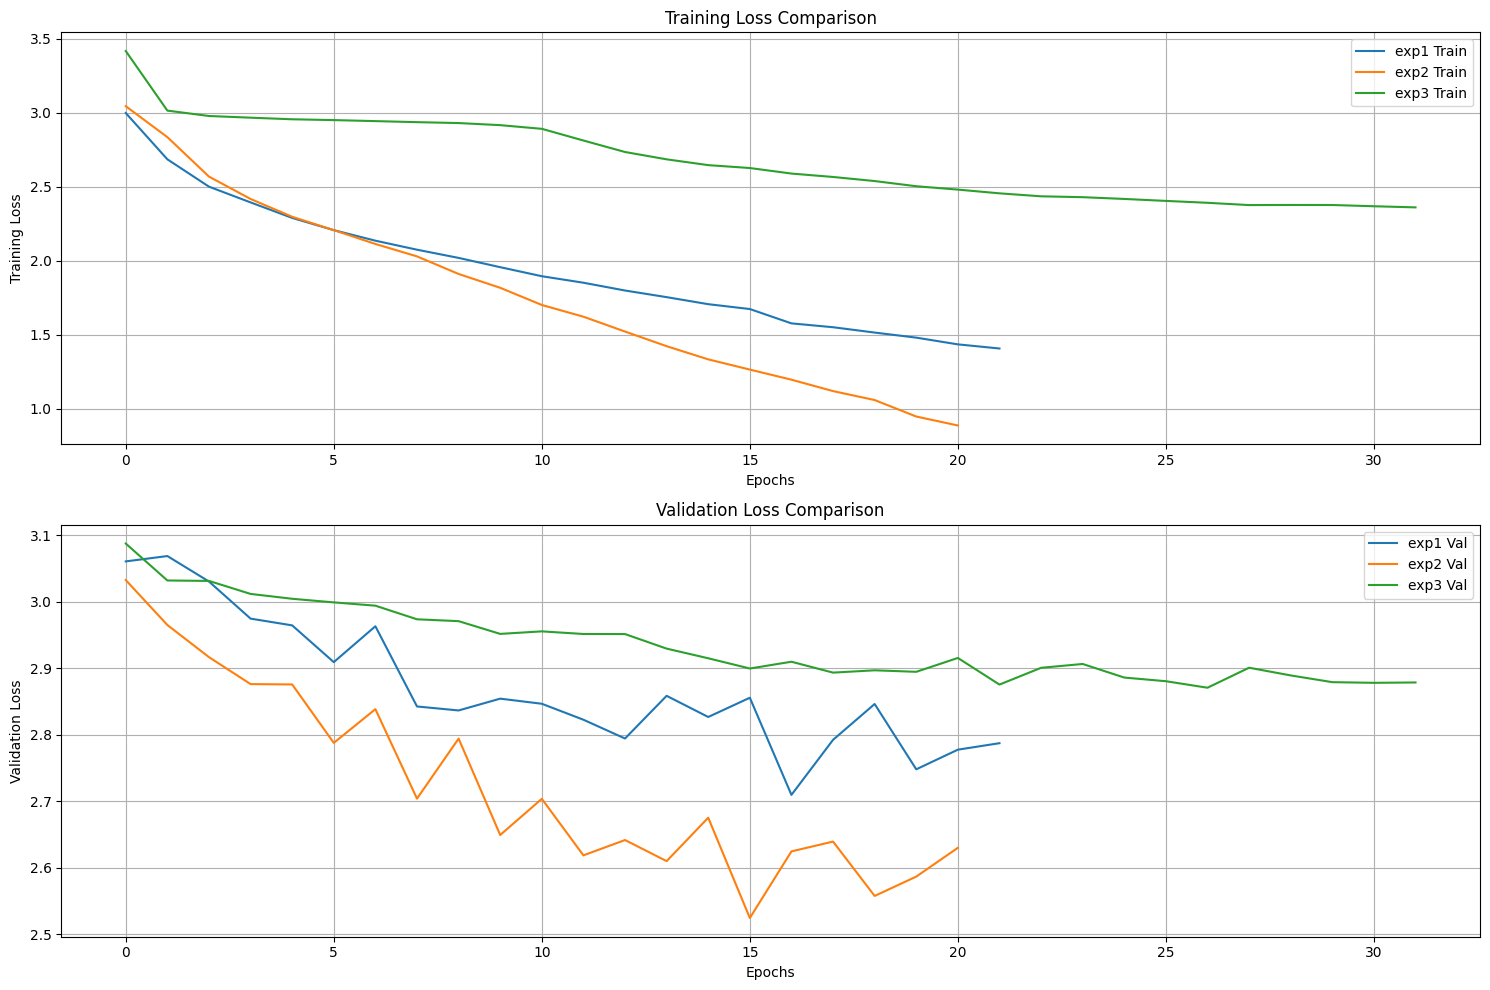

In [12]:
# Extract test pairs from the original dataset
N = len(pairs_with_file)
train_end = N//2
val_end = train_end + N//4
test_pairs = pairs_with_file[val_end:]

print(f"Total pairs: {N}")
print(f"Train pairs: {train_end}")
print(f"Validation pairs: {val_end - train_end}")
print(f"Test pairs: {len(test_pairs)}")

# Run all experiments
all_results = []
for config in hyperparameter_configs:
    result = run_experiment(config, train_loader, val_loader, test_loader, vocab_size, device)
    all_results.append(result)

# Compare results
print("\n" + "="*50)
print("EXPERIMENT COMPARISON")
print("="*50)
print(f"{'Experiment':<10} {'BLEU':<8} {'CER':<8} {'WER':<8} {'Match Rate':<12} {'Perplexity':<12}")
print("-" * 70)

for result in all_results:
    print(f"{result['name']:<10} "
          f"{result['results']['avg_bleu']:<8.2f} "
          f"{result['results']['avg_cer']:<8.2%} "
          f"{result['results']['avg_wer']:<8.2%} "
          f"{result['results']['exact_match_rate']:<12.2%} "
          f"{result['results']['perplexity']:<12.2f}")

# Find best model based on BLEU score
best_result = max(all_results, key=lambda x: x['results']['avg_bleu'])
print(f"\nBest Model: {best_result['name']} with BLEU score of {best_result['results']['avg_bleu']:.2f}")

# Plot learning curves for all experiments
plt.figure(figsize=(15, 10))

# Plot training losses
plt.subplot(2, 1, 1)
for result in all_results:
    plt.plot(result['train_losses'], label=f"{result['name']} Train")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Plot validation losses
plt.subplot(2, 1, 2)
for result in all_results:
    plt.plot(result['val_losses'], label=f"{result['name']} Val")
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 10. Final Evaluation of Best Model

In [13]:
# Load the best model from the best experiment
best_model_name = best_result['name']
checkpoint = torch.load(f"{best_model_name}_best_model.pt")

# Initialize model with best configuration
best_config = best_result['config']
encoder = Encoder(vocab_size, best_config["embed_size"], best_config["hidden_size"], 
                  num_layers=best_config["num_layers_enc"], dropout=best_config["dropout"])
decoder = Decoder(vocab_size, best_config["embed_size"], best_config["hidden_size"], 
                  num_layers=best_config["num_layers_dec"], dropout=best_config["dropout"])

# Load state dictionaries
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

# Move to device
encoder.to(device)
decoder.to(device)

# Create transliterator with best model
best_transliterator = Transliterator(encoder, decoder, tokenizer, device, best_config["num_layers_dec"])

# Run final comprehensive evaluation
print("\n" + "="*50)
print("FINAL EVALUATION OF BEST MODEL")
print("="*50)
final_results = evaluate_comprehensive(best_transliterator, test_pairs, num_samples=500)

# Print summary metrics
print(f"BLEU Score: {final_results['avg_bleu']:.2f}")
print(f"Character Error Rate (CER): {final_results['avg_cer']:.2%}")
print(f"Word Error Rate (WER): {final_results['avg_wer']:.2%}")
print(f"Exact Match Rate: {final_results['exact_match_rate']:.2%}")
print(f"Perplexity: {final_results['perplexity']:.2f}")
print("="*50)

# Display qualitative examples
print("\nQUALITATIVE EXAMPLES FROM BEST MODEL")
print("="*50)

# Sort examples by BLEU score (worst first)
examples_sorted = sorted(final_results["examples"], key=lambda x: x["bleu"])

print("\nTop 5 Worst Predictions (Low BLEU):")
for i, example in enumerate(examples_sorted[:5]):
    print(f"\nExample #{i+1} (BLEU: {example['bleu']:.2f}, CER: {example['cer']:.2%})")
    print(f"Urdu:     {example['urdu']}")
    print(f"Reference: {example['reference']}")
    print(f"Prediction: {example['prediction']}")

print("\n" + "-"*50)

# Show best predictions
examples_sorted_best = sorted(final_results["examples"], key=lambda x: x["bleu"], reverse=True)

print("\nTop 5 Best Predictions (High BLEU):")
for i, example in enumerate(examples_sorted_best[:5]):
    print(f"\nExample #{i+1} (BLEU: {example['bleu']:.2f}, CER: {example['cer']:.2%})")
    print(f"Urdu:     {example['urdu']}")
    print(f"Reference: {example['reference']}")
    print(f"Prediction: {example['prediction']}")

print("\n" + "-"*50)

# Show exact matches
exact_matches_examples = [ex for ex in final_results["examples"] if ex["reference"].strip() == ex["prediction"].strip()]

print(f"\nExact Matches ({len(exact_matches_examples)} examples):")
for i, example in enumerate(exact_matches_examples[:5]):
    print(f"\nExample #{i+1}")
    print(f"Urdu:     {example['urdu']}")
    print(f"Reference: {example['reference']}")
    print(f"Prediction: {example['prediction']}")

# Additional analysis: Error patterns
print("\n" + "="*50)
print("ERROR PATTERN ANALYSIS")
print("="*50)

# Analyze common character substitutions
char_substitutions = defaultdict(int)
for example in final_results["examples"]:
    ref = example["reference"].replace(' ', '')
    hyp = example["prediction"].replace(' ', '')

    # Align characters and find substitutions
    for r, h in zip(ref, hyp):
        if r != h:
            char_substitutions[(r, h)] += 1

print("\nMost Common Character Substitutions:")
sorted_subs = sorted(char_substitutions.items(), key=lambda x: x[1], reverse=True)
for (ref_char, hyp_char), count in sorted_subs[:10]:
    print(f"'{ref_char}' → '{hyp_char}': {count} times")

# Save detailed results
detailed_results = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "best_model": best_model_name,
    "best_config": best_config,
    "metrics": {
        "bleu": final_results["avg_bleu"],
        "cer": final_results["avg_cer"],
        "wer": final_results["avg_wer"],
        "exact_match_rate": final_results["exact_match_rate"],
        "perplexity": final_results["perplexity"]
    },
    "examples": final_results["examples"][:20],  # Save first 20 examples
    "error_patterns": {f"{k[0]}→{k[1]}": v for k, v in sorted_subs[:10]}
}

with open("detailed_evaluation_results.json", "w", encoding="utf-8") as f:
    json.dump(detailed_results, f, indent=2, ensure_ascii=False)

print(f"\nDetailed results saved to 'detailed_evaluation_results.json'")


FINAL EVALUATION OF BEST MODEL
BLEU Score: 0.00
Character Error Rate (CER): 60.97%
Word Error Rate (WER): 100.00%
Exact Match Rate: 7.40%
Perplexity: 14.14

QUALITATIVE EXAMPLES FROM BEST MODEL

Top 5 Worst Predictions (Low BLEU):

Example #1 (BLEU: 0.00, CER: 34.78%)
Urdu:     کیوں کہ یہ باز آشیانی ہے
Reference: kyuuñ ki ye baaz āshyānī hai
Prediction: kyuuñkanezafāānānīhai

Example #2 (BLEU: 0.00, CER: 67.65%)
Urdu:     بے گناہی کے لبادے کو اتارو بھی نصیر
Reference: be-gunāhī ke libāde ko utāro bhī 'nasīr'
Prediction: be-galāgayāhakoaaaatīsanar

Example #3 (BLEU: 0.00, CER: 52.17%)
Urdu:     ناؤ ڈالی اور دھارا اور ہے
Reference: naav daalī aur dhārā aur hai
Prediction: naañdardkīdalāāārahāhai

Example #4 (BLEU: 0.00, CER: 40.00%)
Urdu:     یہ زندگی ہے تو پھر زندگی کو کیا کیجے
Reference: ye zindagī hai to phir zindagī ko kyā kiije
Prediction: yezararhaitohaiaaaakokyākaiije

Example #5 (BLEU: 0.00, CER: 56.76%)
Urdu:     کہانی میں تو کرداروں کو جو چاہے بنا دیجے
Reference: kahānī meñ to

# 11. Save Best Model

In [14]:
# Save the best model with all necessary information
torch.save({
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict(),
    'tokenizer_path': "data/processed/bpe_tokenizer.json",
    'config': best_config,
    'vocab_size': vocab_size,
    'PAD_ID': PAD_ID,
    'CLS_ID': CLS_ID,
    'SEP_ID': SEP_ID,
    'results': final_results,
    'experiment_name': best_model_name
}, 'urdu_to_roman_bilstm_model.pt')

print(f"Best model ({best_model_name}) saved successfully!")

Best model (exp1) saved successfully!


# 12. Inference

In [19]:
# Initialize transliterator with the best model
transliterator = best_transliterator

# Test with some examples
test_examples = [
    "میرا نام یحییٰ ہے",
    "میرا نام غیاث ہے",
    "میں اردو بولتا ہوں"
]

print("\nTesting the best model:")
for example in test_examples:
    transliteration = transliterator.transliterate(example)
    print(f"Urdu: {example} -> Roman: {transliteration}")

# Additional test with user input
print("\nTry your own examples (type 'exit' to quit):")
while True:
    user_input = input("Enter Urdu text: ")
    if user_input.lower() == 'exit':
        break
    transliteration = transliterator.transliterate(user_input)
    print(f"Transliteration: {transliteration}")


Testing the best model:
Urdu: میرا نام یحییٰ ہے -> Roman: merānamanīīhai
Urdu: میرا نام غیاث ہے -> Roman: merānamahāāhilhai
Urdu: میں اردو بولتا ہوں -> Roman: maiñaadābhītohuuñ

Try your own examples (type 'exit' to quit):
Transliteration: kalhambazrjā.eñge
